### Blog post on low wage work and employment rates

January 23, 2019

Brian Dew, @bd_econ

----

Originally published on bd econ blog, [here](https://briandew.wordpress.com/2019/01/24/higher-employment-rates-mean-higher-wages-for-low-wage-workers/).

In [12]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

# bd CPS files
cps_dir = Path('/home/brian/Documents/CPS/data/clean/')

# Get names of CBSAs
url = 'https://www.uspto.gov/web/offices/ac/ido/oeip/taf/cls_cbsa/cbsa_countyassoc.htm'
cbsa_list = pd.read_html(url)[0]
cbsas = cbsa_list.set_index('CBSA Code')['CBSA Title'].to_dict()
# Fill in the gaps:
d = {14010: 'Bloomington, IL',
     15680: 'California-Lexington Park, MD',
     16060: 'Carbondale-Marion, IL',
     16540: 'Chambersburg-Waynesboro, PA',
     19300: 'Daphne-Fairhope-Foley, AL',
     20700: 'East Stroudsburg, PA',
     25940: 'Hilton Head Island-Bluffton-Beaufort, SC',
     27980: 'Kahului-Wailuku-Lahaina, HI',
     29200: 'Lafayette-West Lafayette, IN',
     31080: 'Los Angeles-Long Beach-Anaheim, CA',
     42200: 'Santa Maria-Santa Barbara, CA',
     46520: 'Urban Honolulu, HI',
     48060: 'Watertown-Fort Drum, NY'}

cbsa_dict = {**cbsas, **d}

# Save CBSA names 
pd.Series(cbsa_dict).to_csv('CBSA_Names.csv')

# Define various functions to apply to grouped data
def epop(group):
    """Calculate epop for group"""
    cats = group.groupby('LFS')['BASICWGT'].sum()
    return cats['Employed'] / cats.sum() * 100.0

# Binned Wage Calculation
def binned_wage(df, wage_var='RHRWAGE', percentile=0.1, wgt_var='PWORWGT',
                bins=np.arange(0.25, 300, .5)):
    '''
    Returns wage estimate based on linear interpolation through 
    the bin containing the wage.
    
    perc = percentile of interest (0.5 is median)
    bins = list of bin start locations
    '''
    cdf = (df.groupby(pd.cut(df[wage_var], bins))
             [wgt_var].sum().cumsum() / df[wgt_var].sum())
    
    return np.interp(percentile, cdf, bins[1:])


In [17]:
# Retrieve latest two years of CPS data
cols = ['YEAR', 'MONTH', 'AGE', 'BASICWGT', 'LFS', 'PRICEADJ',
        'WORKFT', 'PWORWGT', 'HRWAGE', 'CBSA']
query = '25 <= AGE <= 54'
df = pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=cols).query(query)
                for year in range(2021, 2024)])
df['RHRWAGE'] = df['HRWAGE'] * df['PRICEADJ']

In [37]:
# Apply calculations and save results
data = pd.DataFrame()
data['EPOP'] = df.groupby('CBSA').apply(epop)
data['P10wage'] = df.query('WORKFT == 1').groupby('CBSA').apply(lambda x: binned_wage(x))
#data['Union'] = df.groupby('CBSA').apply(unionmem)
#data['Unemp'] = df.groupby('CBSA').apply(unemp)
data['Name'] = data.index.map(cbsa_dict)
#data.to_csv('CBSA_2YR_Indicators.csv')
data = data[(df.groupby('CBSA').HRWAGE.count() > 200)].dropna()

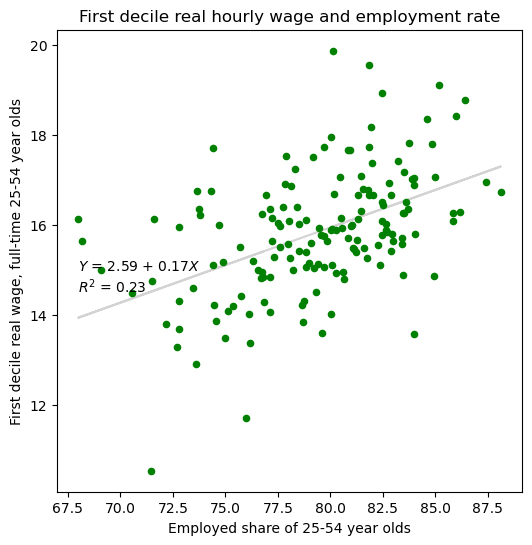

In [38]:
# Scatter plot of epop and first decile wage
y = data['P10wage']
x = data['EPOP']

r2 = np.corrcoef(x, y)[0, 1]**2
fit = np.polyfit(x, y, 1)

data.plot(kind='scatter', x='EPOP', y='P10wage', 
          zorder=2, color='green', figsize=(6, 6))
plt.plot(x, np.poly1d(fit)(x), color='lightgray', zorder=1)
text = f'$Y$ = {round(fit[1], 2)} + {round(fit[0], 2)}$X$\n$R^2$ = {round(r2, 2)}'
plt.text(x.min(), 14.5, text)
plt.title('First decile real hourly wage and employment rate')
plt.xlabel('Employed share of 25-54 year olds')
plt.ylabel('First decile real wage, full-time 25-54 year olds')
plt.savefig('CBSA_p10wage_epop.png')